# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [1]:
import numpy as np
import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as iv3_input

Using TensorFlow backend.


In [3]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [4]:
import re
from random import shuffle
from glob import glob

train_files = glob('./data/train/*.jpg')
test_files = glob('./data/test1/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return iv3_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

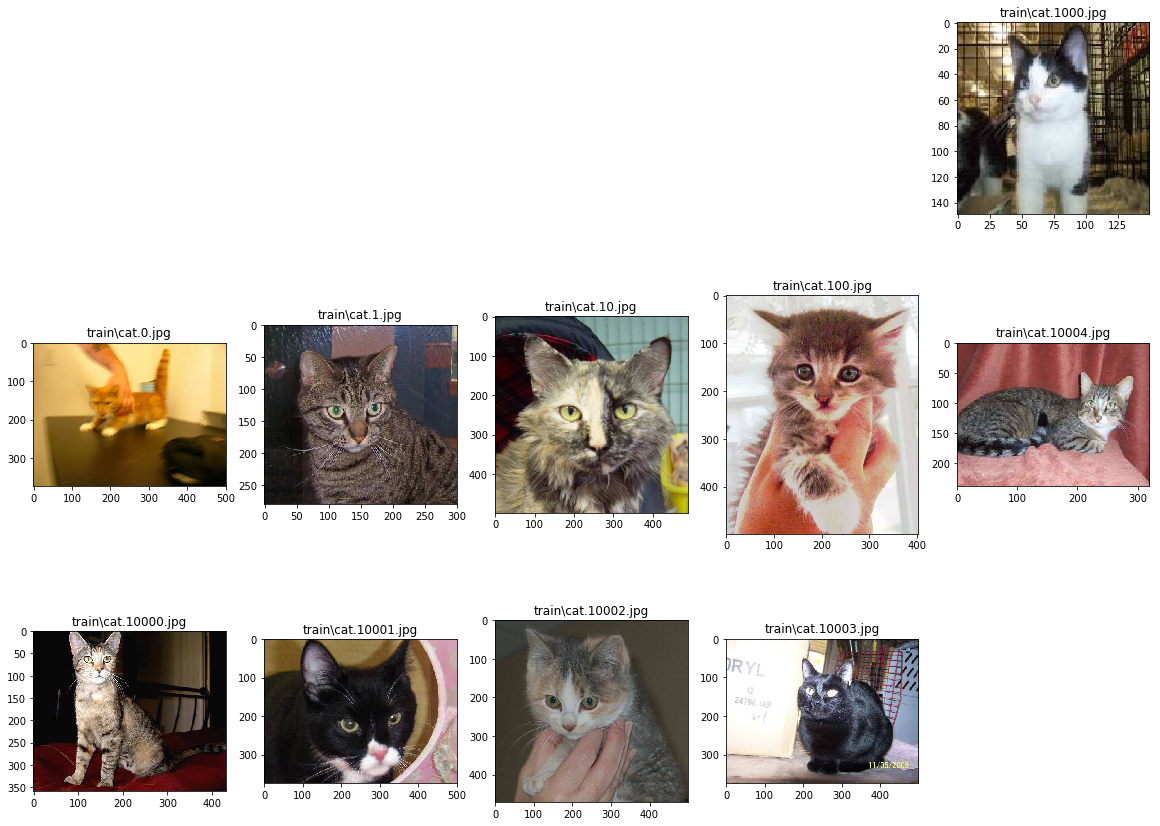

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [2]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = InceptionV3(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

NameError: name 'IMG_SIZE' is not defined

In [50]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

## Выводим архитектуру модели

In [ ]:
base_model.summary()

## Промежуточные фичи

### разобьем тренировочную выборку на три части по 10000 картинок, и для каждой сделаем предикт базовой модели inceptionv3, для теста делаем тоже самое но за один раз

In [53]:
import pickle

In [13]:
%%time
train_stg2_first=base_model.predict_generator(predict_generator(train_files[:10000]), len(train_files[:10000]))

Wall time: 1h 1min 50s


In [14]:
file = open('train_stg2_first', 'wb')

In [15]:
np.save(file, train_stg2_first)

In [16]:
file.close()

In [17]:
%%time
train_stg2_first=base_model.predict_generator(predict_generator(train_files[10000:20000]), len(train_files[10000:20000]))

Wall time: 1h 3min 41s


In [18]:
file = open('train_stg2_second', 'wb')
np.save(file, train_stg2_first)
file.close()

In [19]:
%%time
train_stg2_first=base_model.predict_generator(predict_generator(train_files[20000:]), len(train_files[20000:]))

Wall time: 30min 21s


In [ ]:
file = open('train_stg2_third_2', 'wb')
pickle.dump( train_stg2_first, file)
file.close()

In [51]:
%%time
train_stg2_first=base_model.predict_generator(predict_generator(test_files), len(test_files))

Wall time: 1h 22min 10s


In [54]:
file = open('test_stg2', 'wb')
pickle.dump( train_stg2_first, file)
file.close()

In [55]:
test_stg2 = train_stg2_first.copy()

### потом загрузим и состекаем (сделано что бы при зависании ноута ничего не пропадало)

In [6]:
file = open('train_stg2_first.npz', 'rb')
train_stg2 = np.load(file)
file.close()

In [7]:
file = open('train_stg2_second.npz', 'rb')
train_stg2 = np.vstack((train_stg2, np.load(file)))
file.close()

In [8]:
file = open('train_stg2_third.npz', 'rb')
train_stg2 = np.vstack((train_stg2, np.load(file)))
file.close()

In [14]:
train_stg2.shape

(25000, 5, 5, 2048)

In [15]:
file = open('train_stg2_i', 'wb')
np.save(file, train_stg2)
file.close()

In [10]:
file.close()

### Развернем фильтры в вектор

In [11]:
train_stg2_flat=train_stg2.reshape(25000, 5*5*2048)

In [47]:
len(test_files)

12500

In [38]:
y = np.array([1. if re.match('.*dog\.\d+.*', path) else 0. for path in train_files])

In [40]:
np.nonzero(y==1)

(array([12500, 12501, 12502, ..., 24997, 24998, 24999], dtype=int64),)

## Уменьшим размерность признаков при помощи PCA

In [13]:
from sklearn.decomposition import IncrementalPCA

In [18]:
ipca = IncrementalPCA(n_components=1000, batch_size=32)

In [19]:
chunk_size = 1000

In [20]:
n=25000

In [21]:
for i in range(0, n//chunk_size):
    ipca.partial_fit(train_stg2_flat[i*chunk_size : (i+1)*chunk_size], y)

D:\distr\anaconda\lib\site-packages\sklearn\decomposition\incremental_pca.py:261: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
D:\distr\anaconda\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [22]:
train_pca = ipca.transform(train_stg2_flat)

In [24]:
file = open('train_pca.npz', 'wb')
np.save(file, train_pca)
file.close()

## Используем обычную линейную регресию в качестве последнего слоя нейронки

### сеть обучается слишком долго, GridSearch не делал т.к. в целом задание не про регрессию

In [25]:
from sklearn.linear_model import LogisticRegression

In [101]:
logreg = LogisticRegression(C=0.0001)

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [41]:
y_train, y_val, x_train, x_val = train_test_split(
    y, train_pca, test_size=0.2, random_state=42)

In [42]:
train_stg2 = None

In [97]:
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Проверяем на валидационной выборке

In [98]:
predval = logreg.predict_proba(x_val)[:,1]

In [89]:
from sklearn.metrics import log_loss

In [6]:
log_loss(y_val,predval)

In [102]:
logreg.fit(train_pca, y)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## Обучаем модель на всех данных и предсказываем класс для теста

In [61]:
test_pca = ipca.transform(test_stg2.reshape(test_stg2.shape[0], 5*5*2048))

In [103]:
pred = logreg.predict_proba(test_pca)[:,1]

## Готовим данные для сабмита

In [105]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        fileid= re.search('(\d+)\.', path).group(1)
        dst.write('%s,%f\n' % (fileid, score))

In [ ]:
# LogLoss = 0.05